In [1]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic

pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

In [2]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})
mpl.rcParams['hatch.linewidth'] = 0.8

In [53]:
def read_timescales():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

In [7]:
print(list(np.unique(data.haloid)))

[1, 4, 10, 21, 27, 31, 35, 37, 45, 47, 48, 49, 67, 71, 81, 102, 131, 407, 418, 1534, 2551, 8678, 9724, 11563]


# Stellar Metallicity Heatmaps

Here we make 2-dimensional heatmaps of stellar metallicity vs stellar age for all the star particles in an individual halo. This lets us more easily discern whether we have multiple, disctinct stellar populations within one galaxy. 


Loaded h148 halo 28


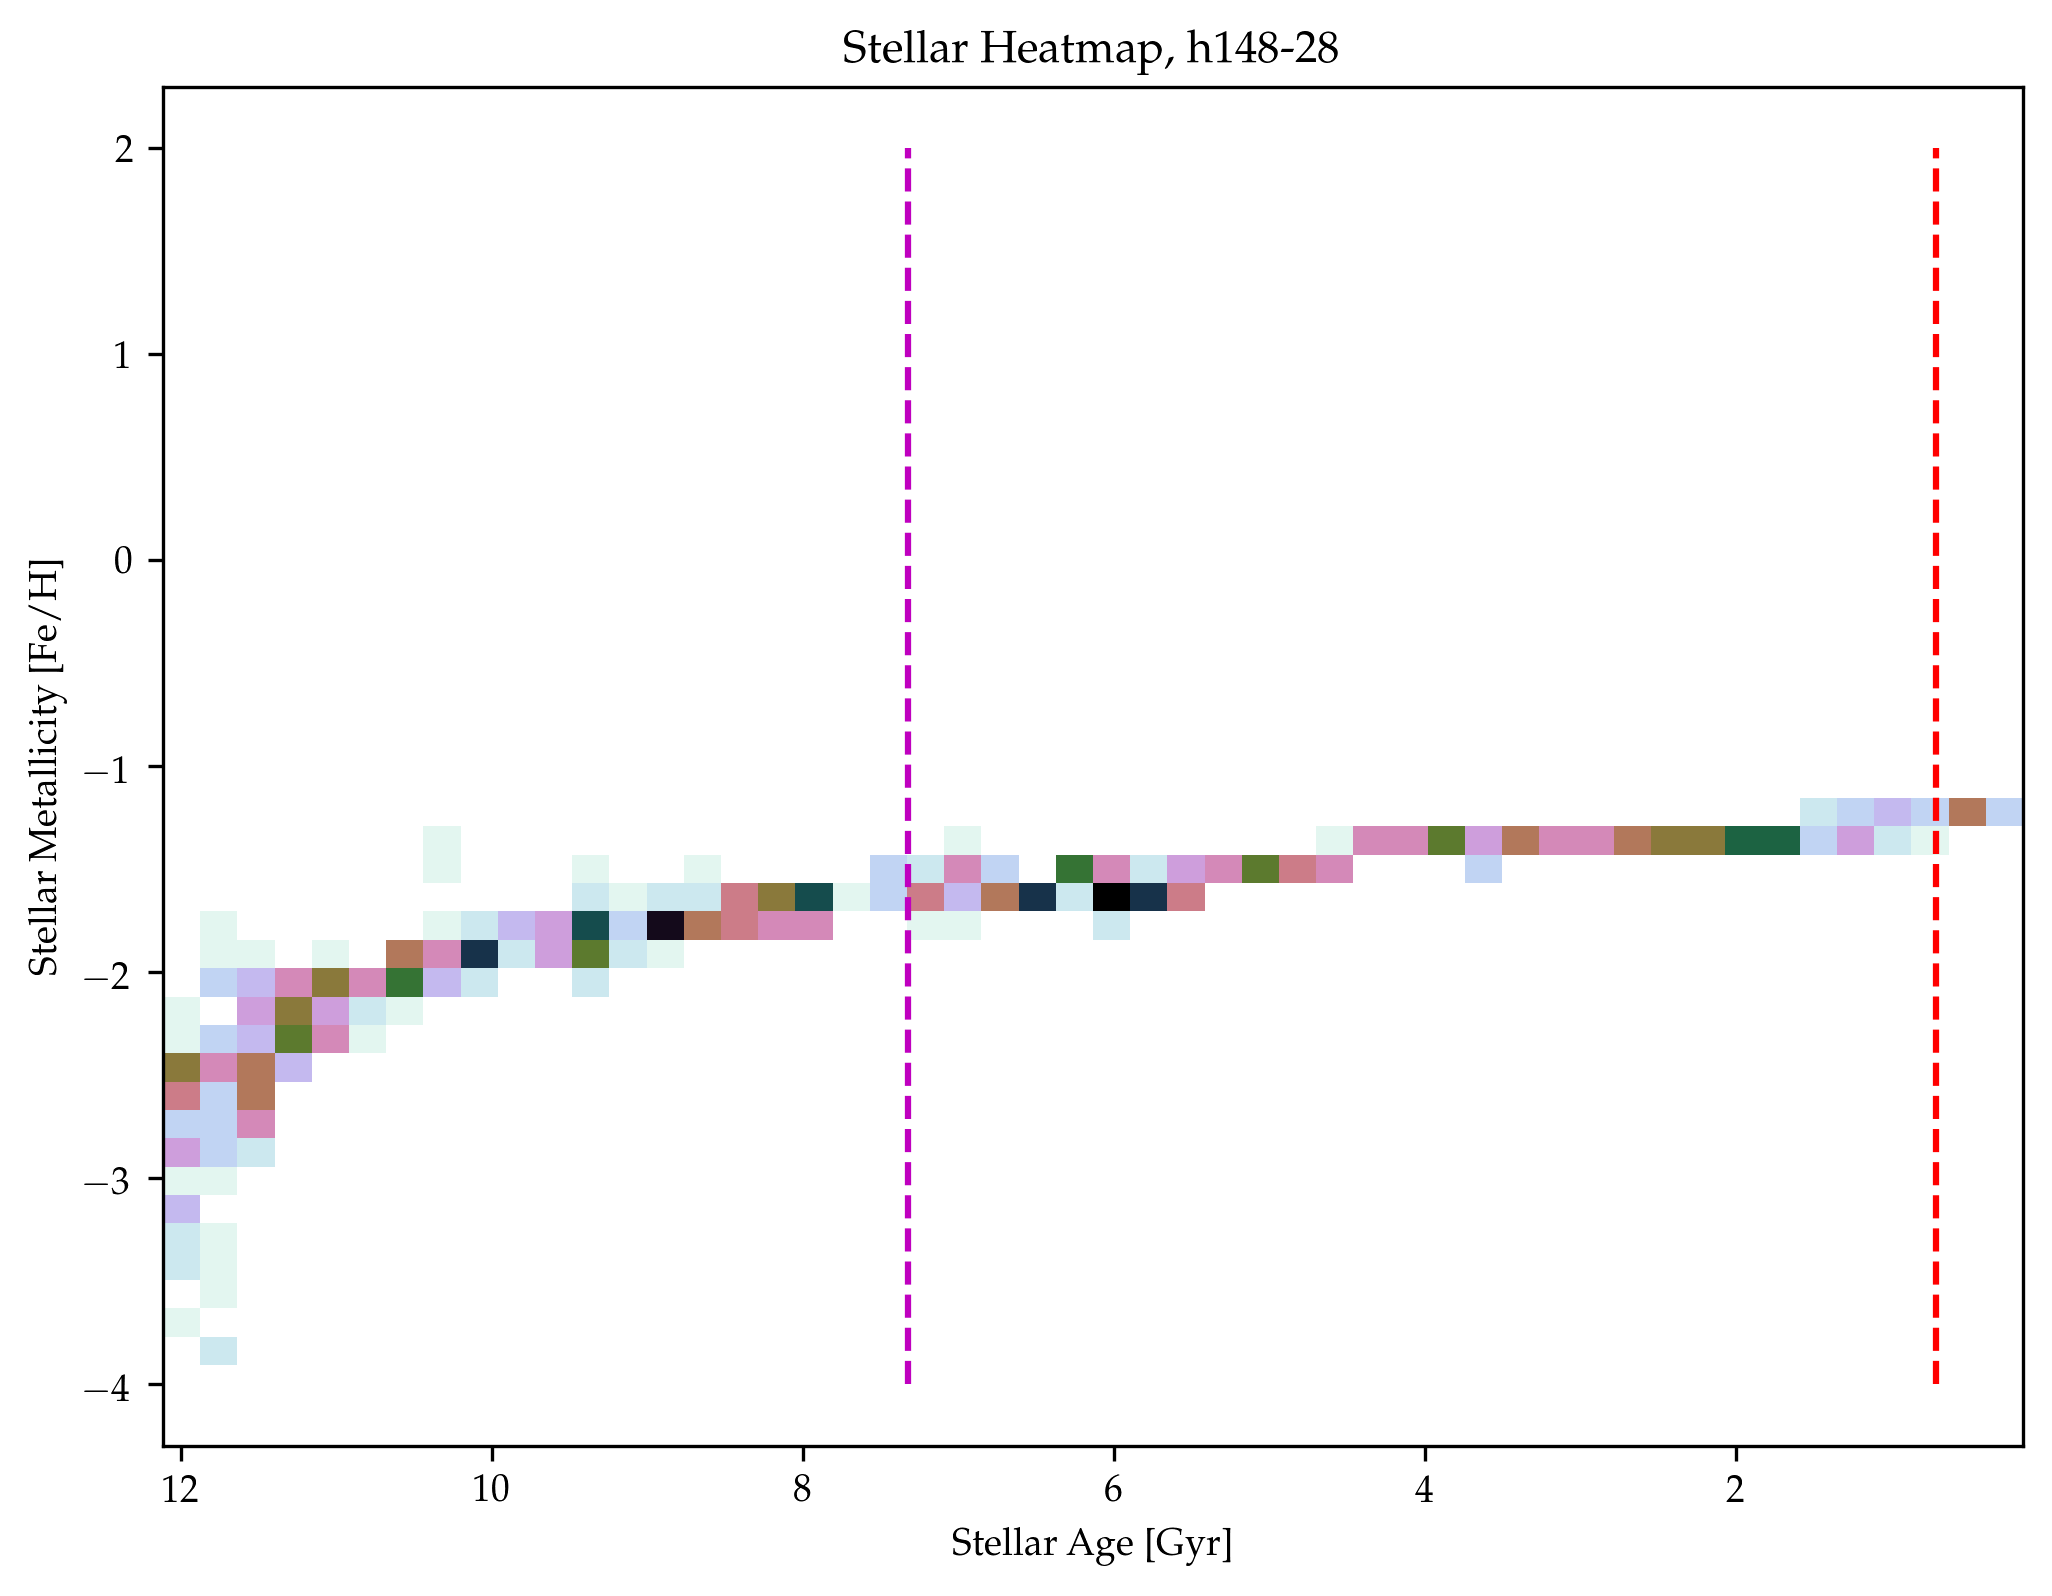

Loaded h148 halo 37


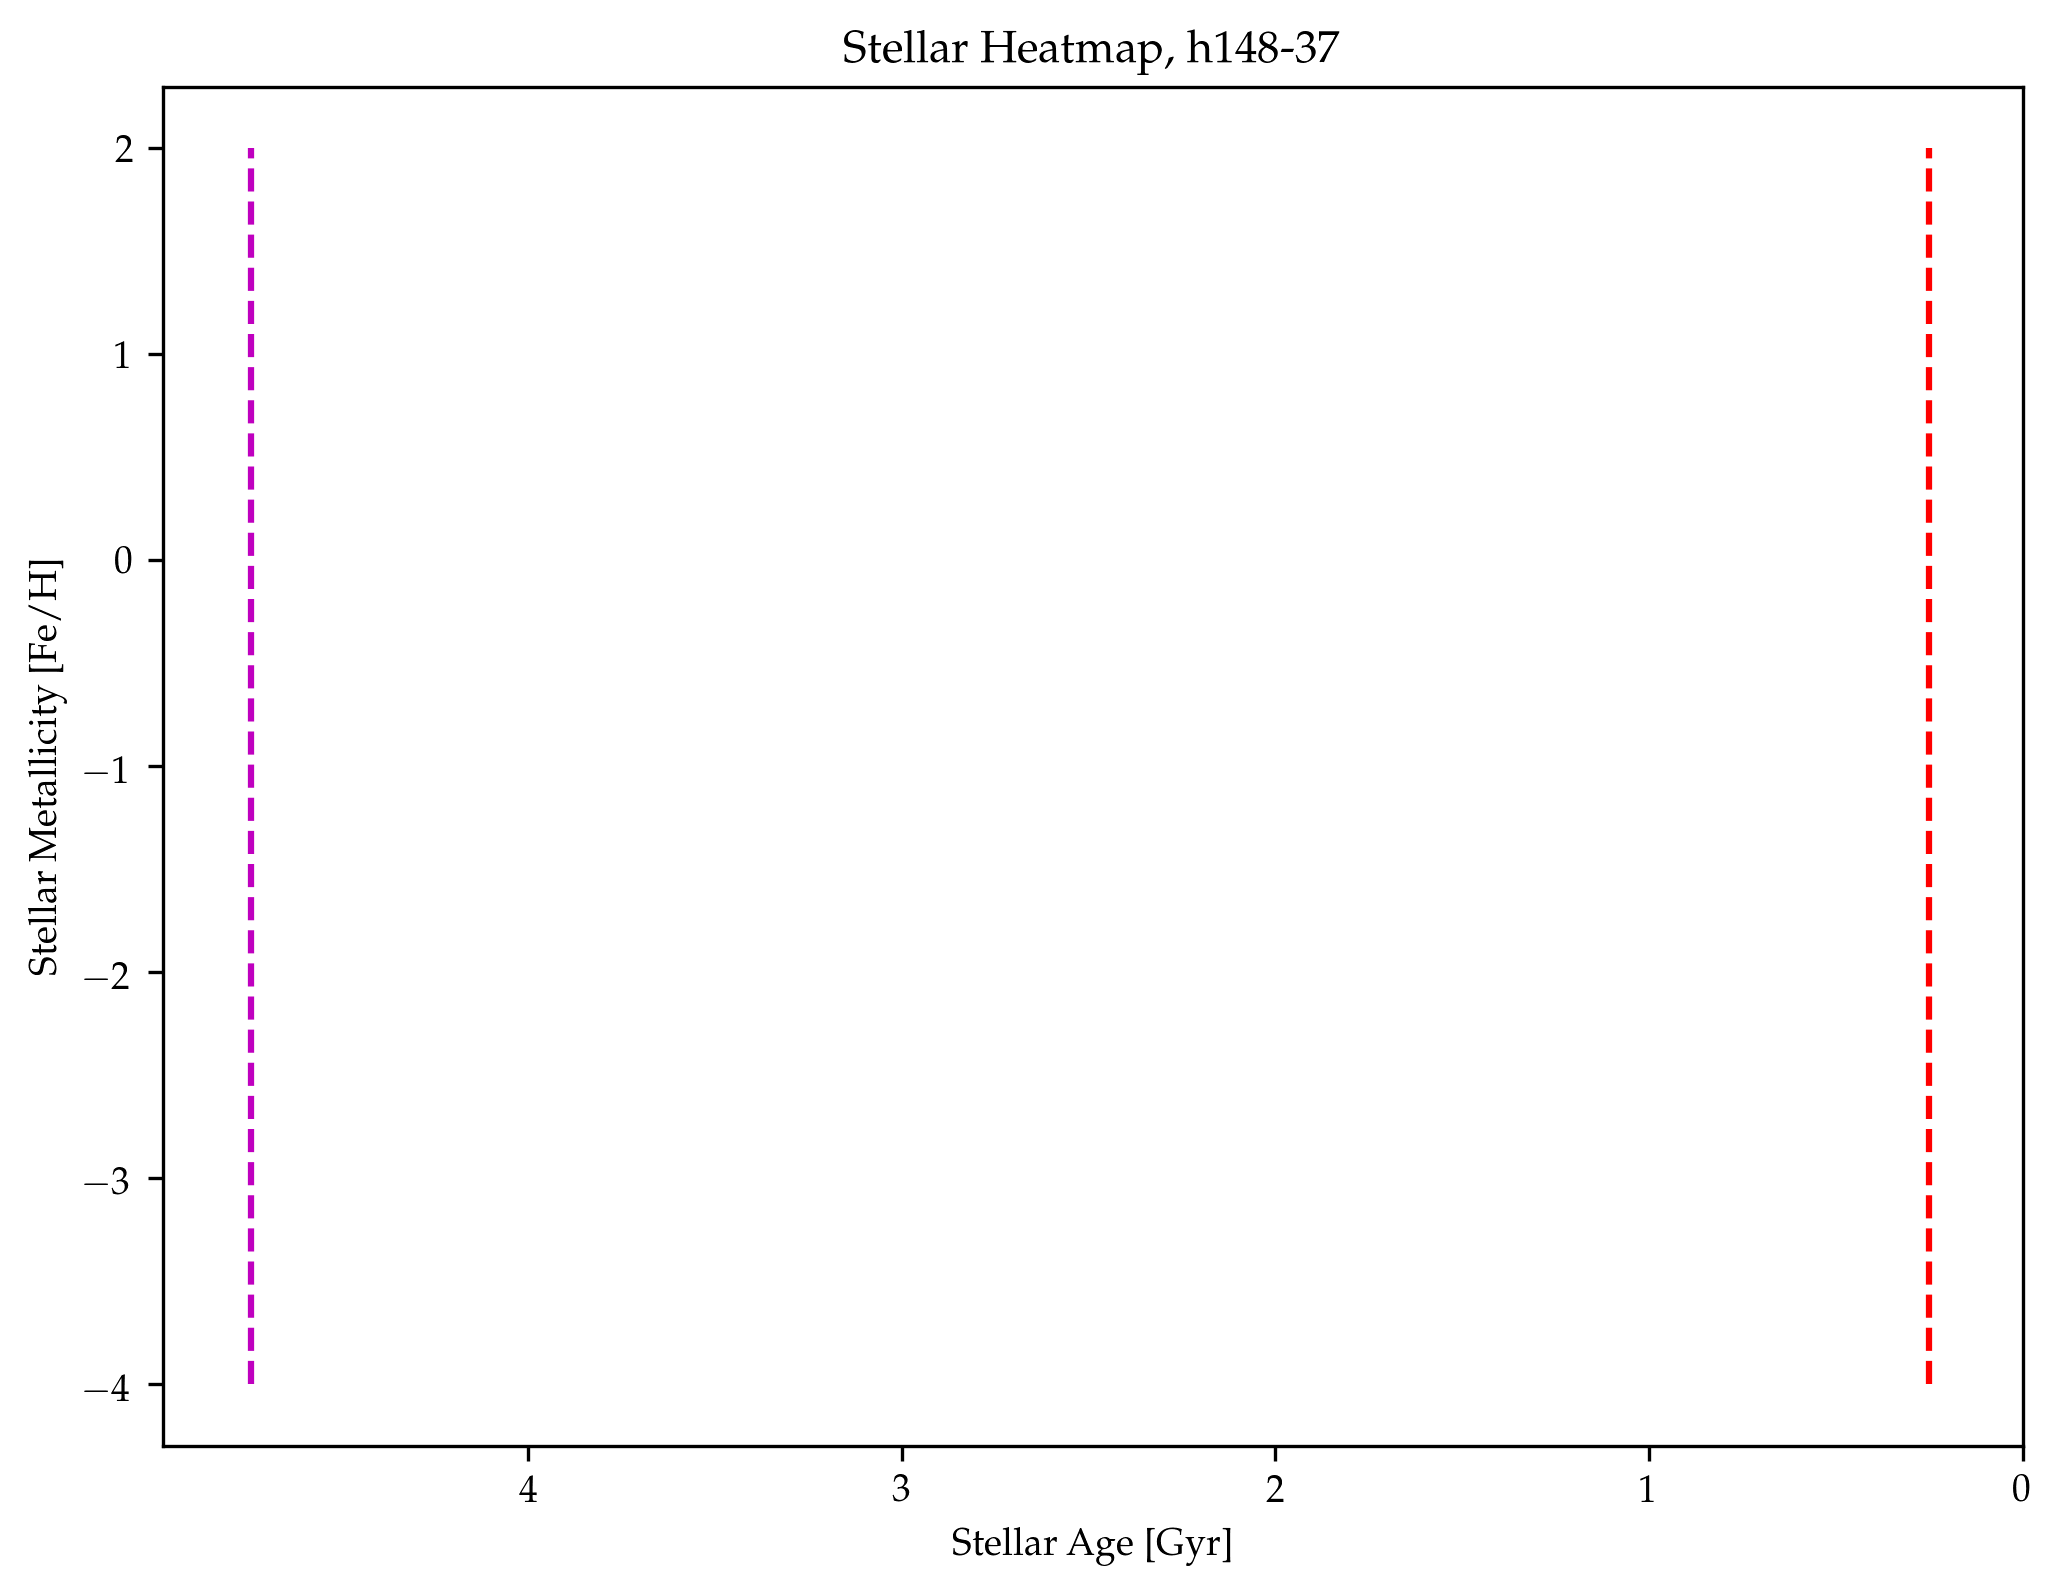

Loaded h148 halo 45


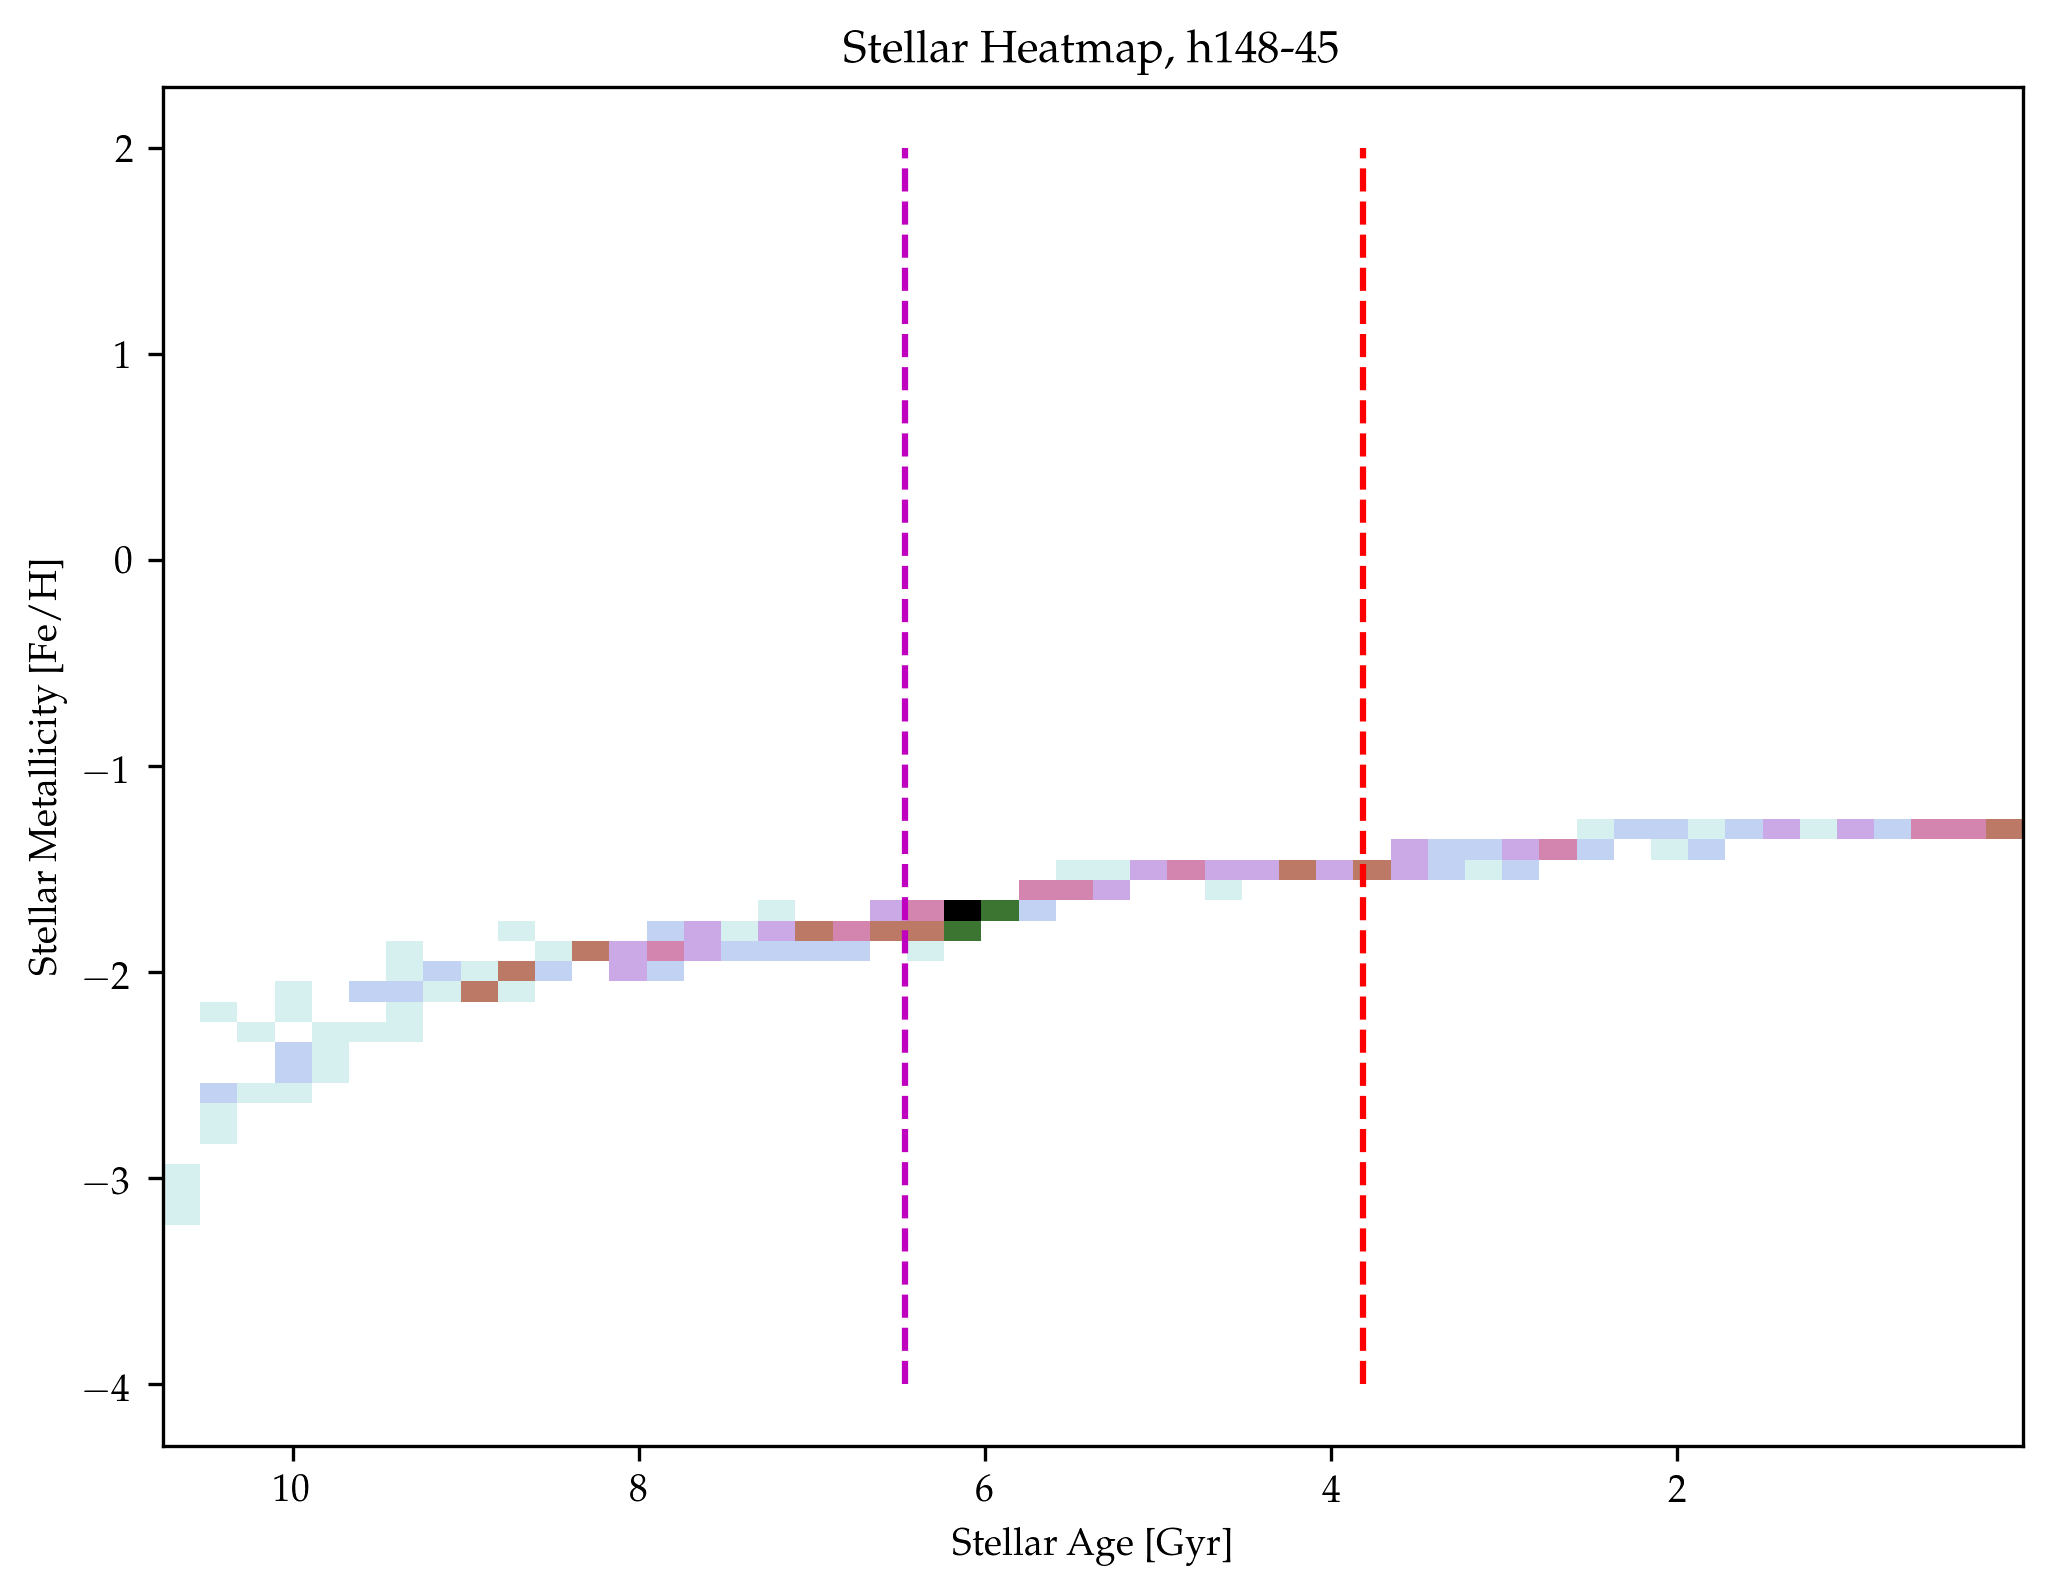

Loaded h148 halo 68


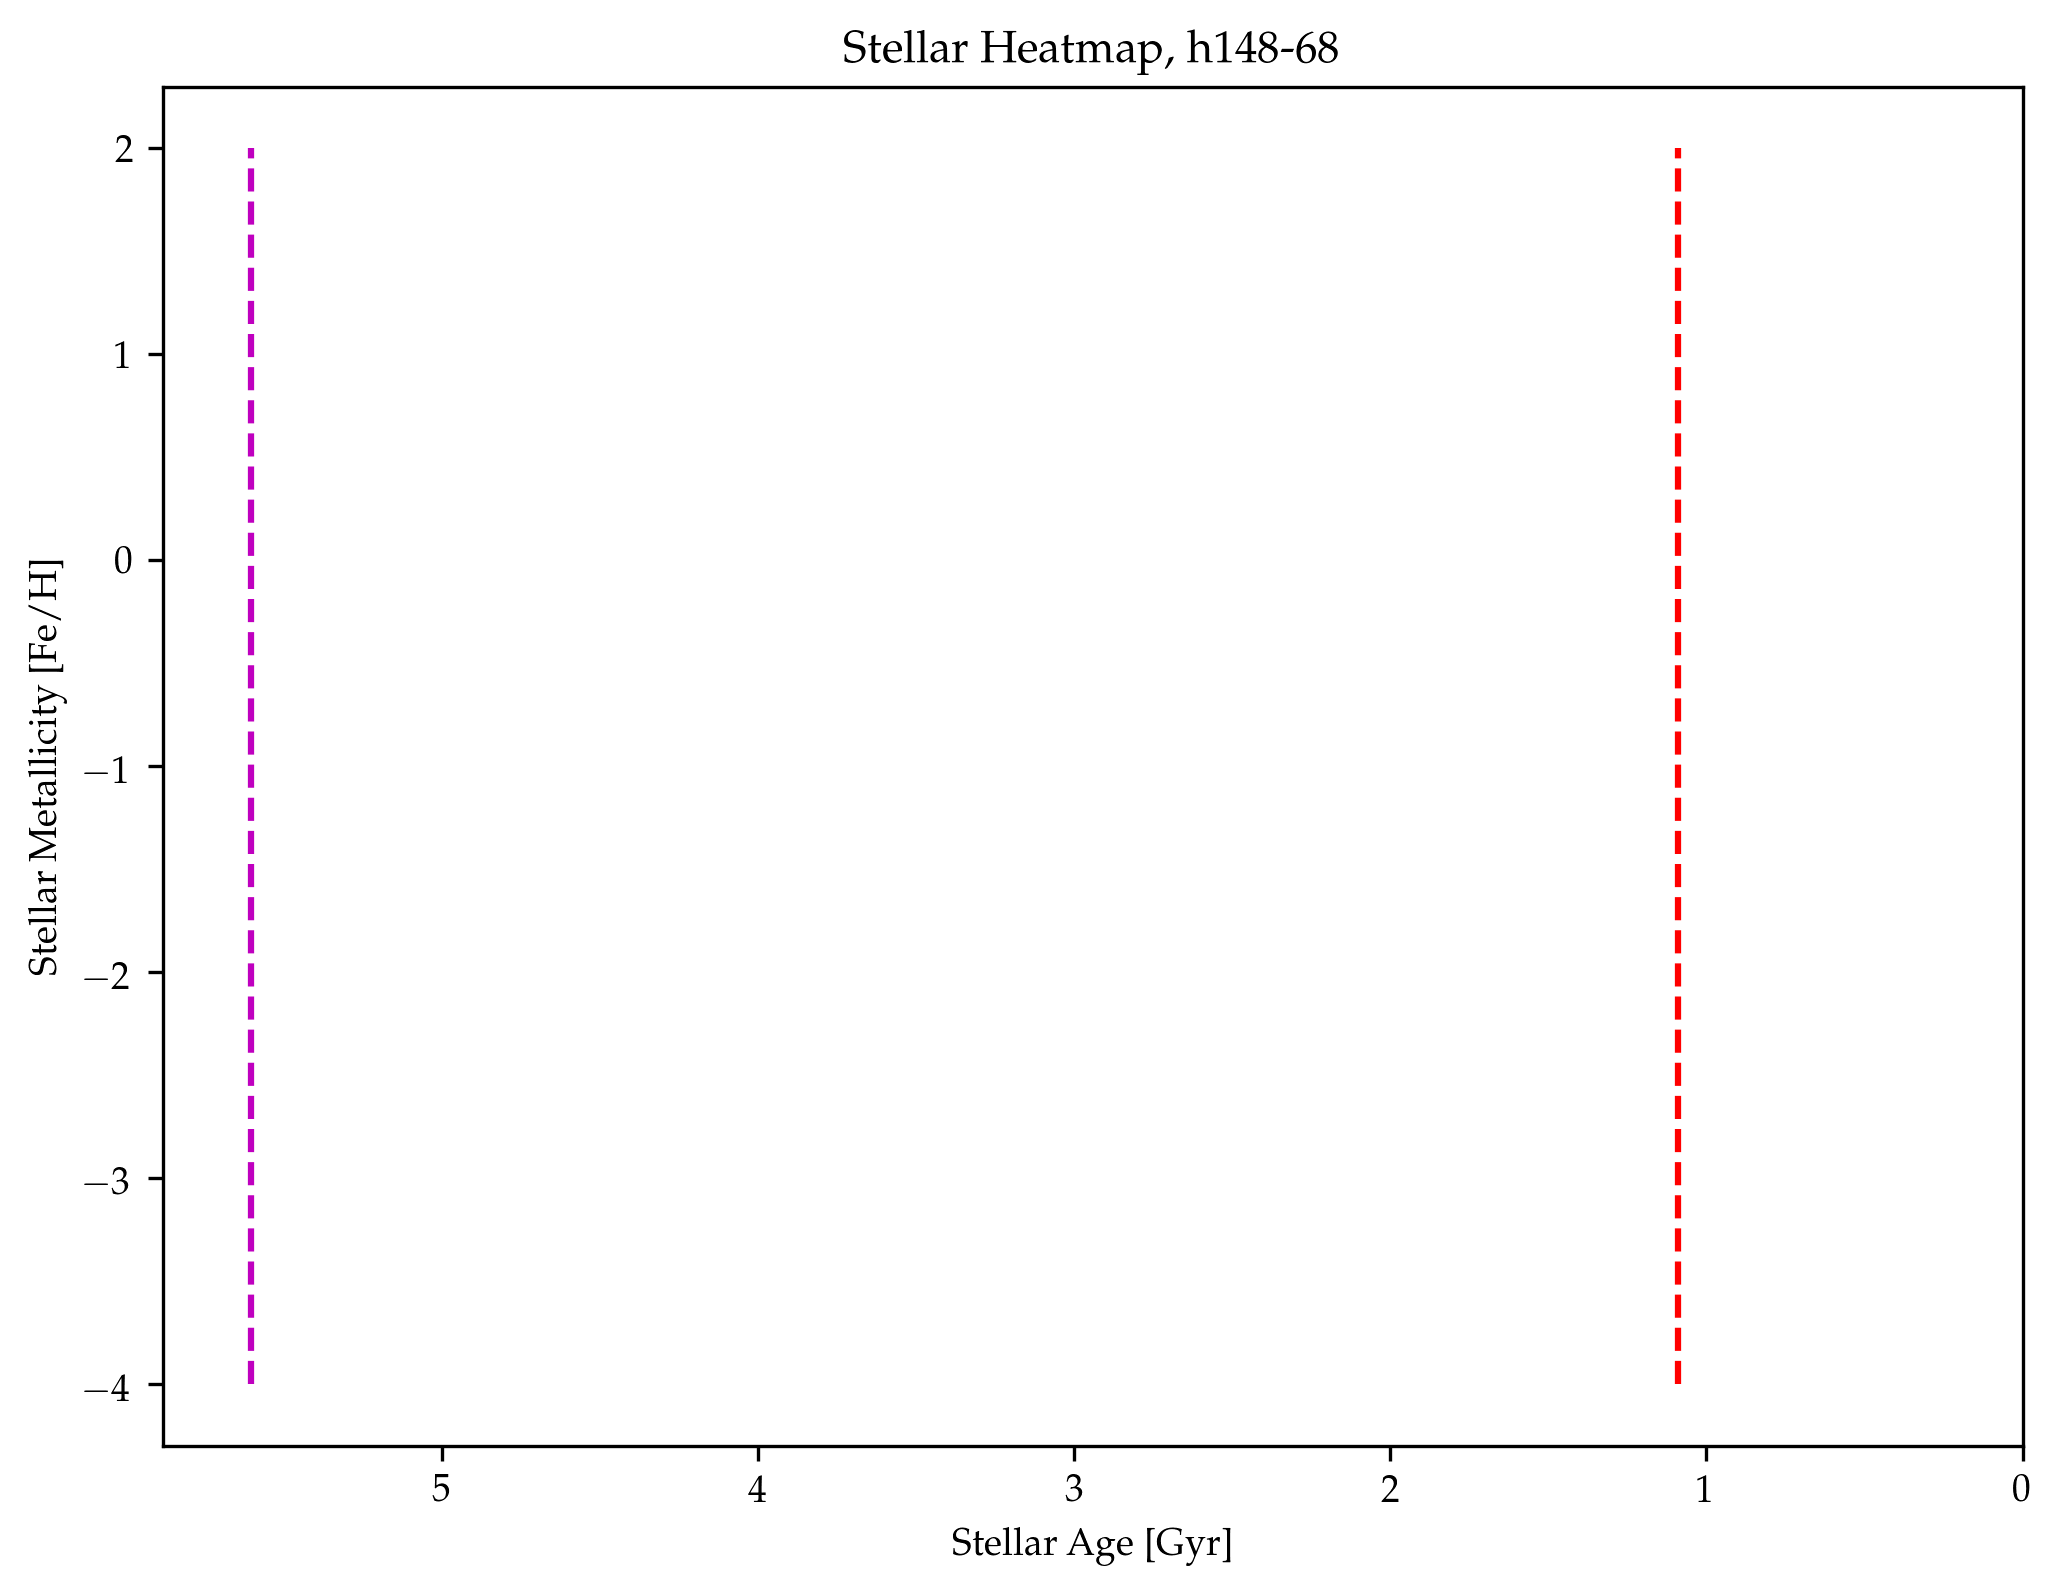

Loaded h242 halo 24


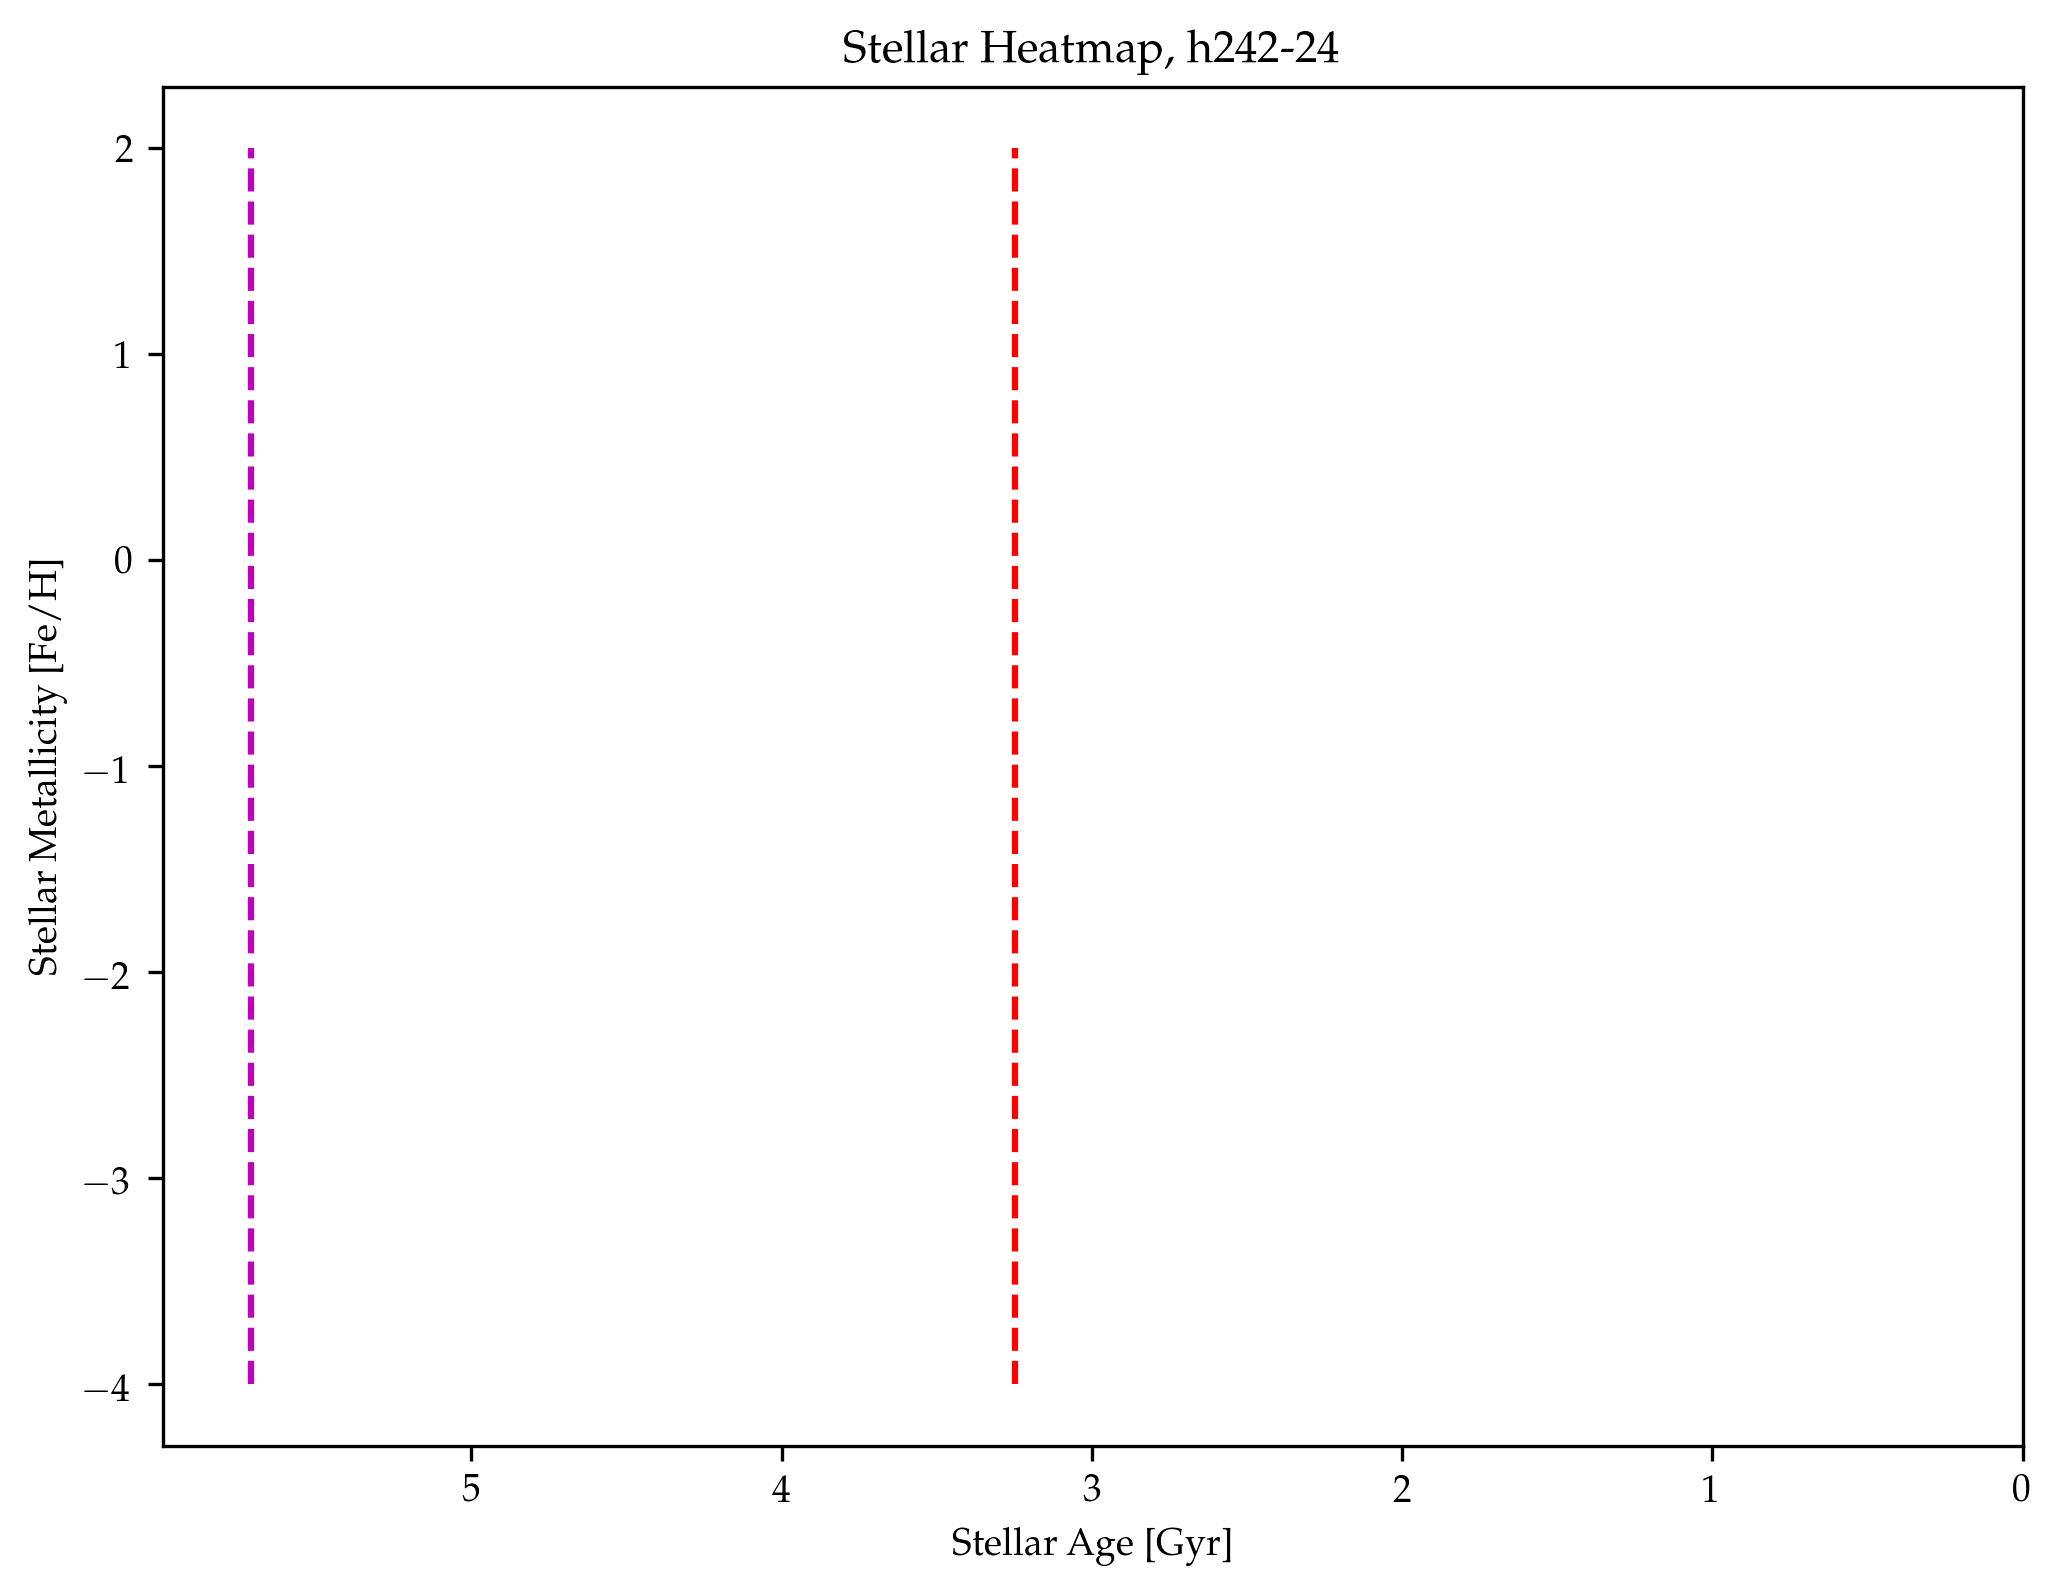

Loaded h242 halo 80


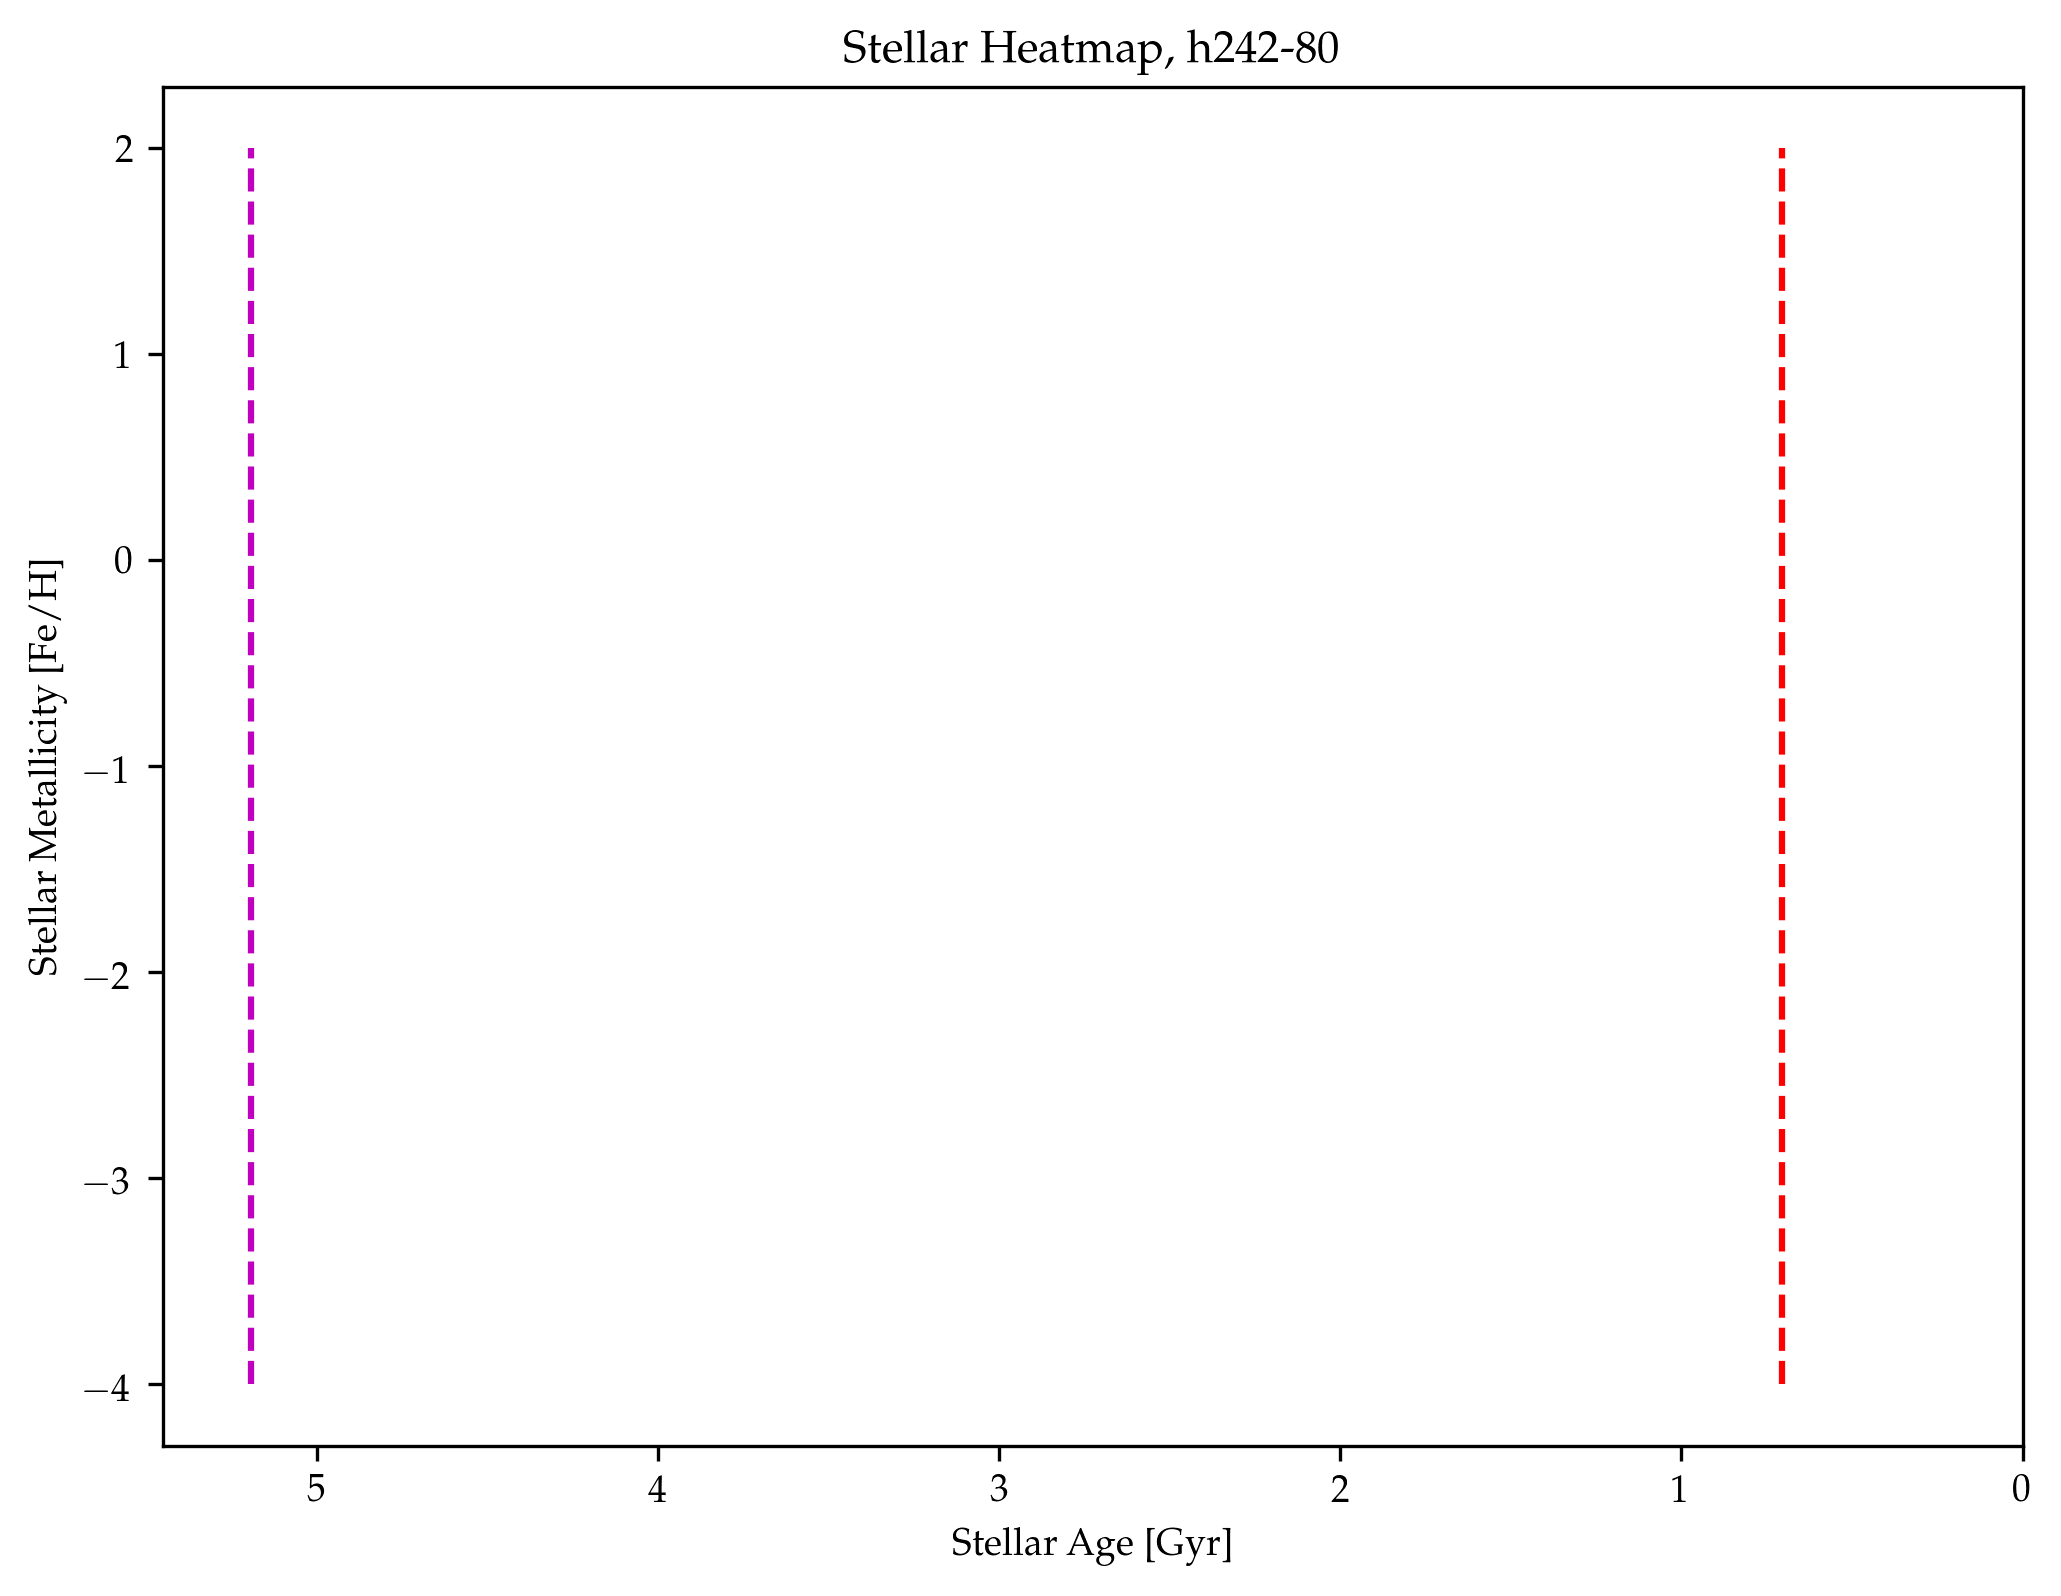

Loaded h229 halo 20


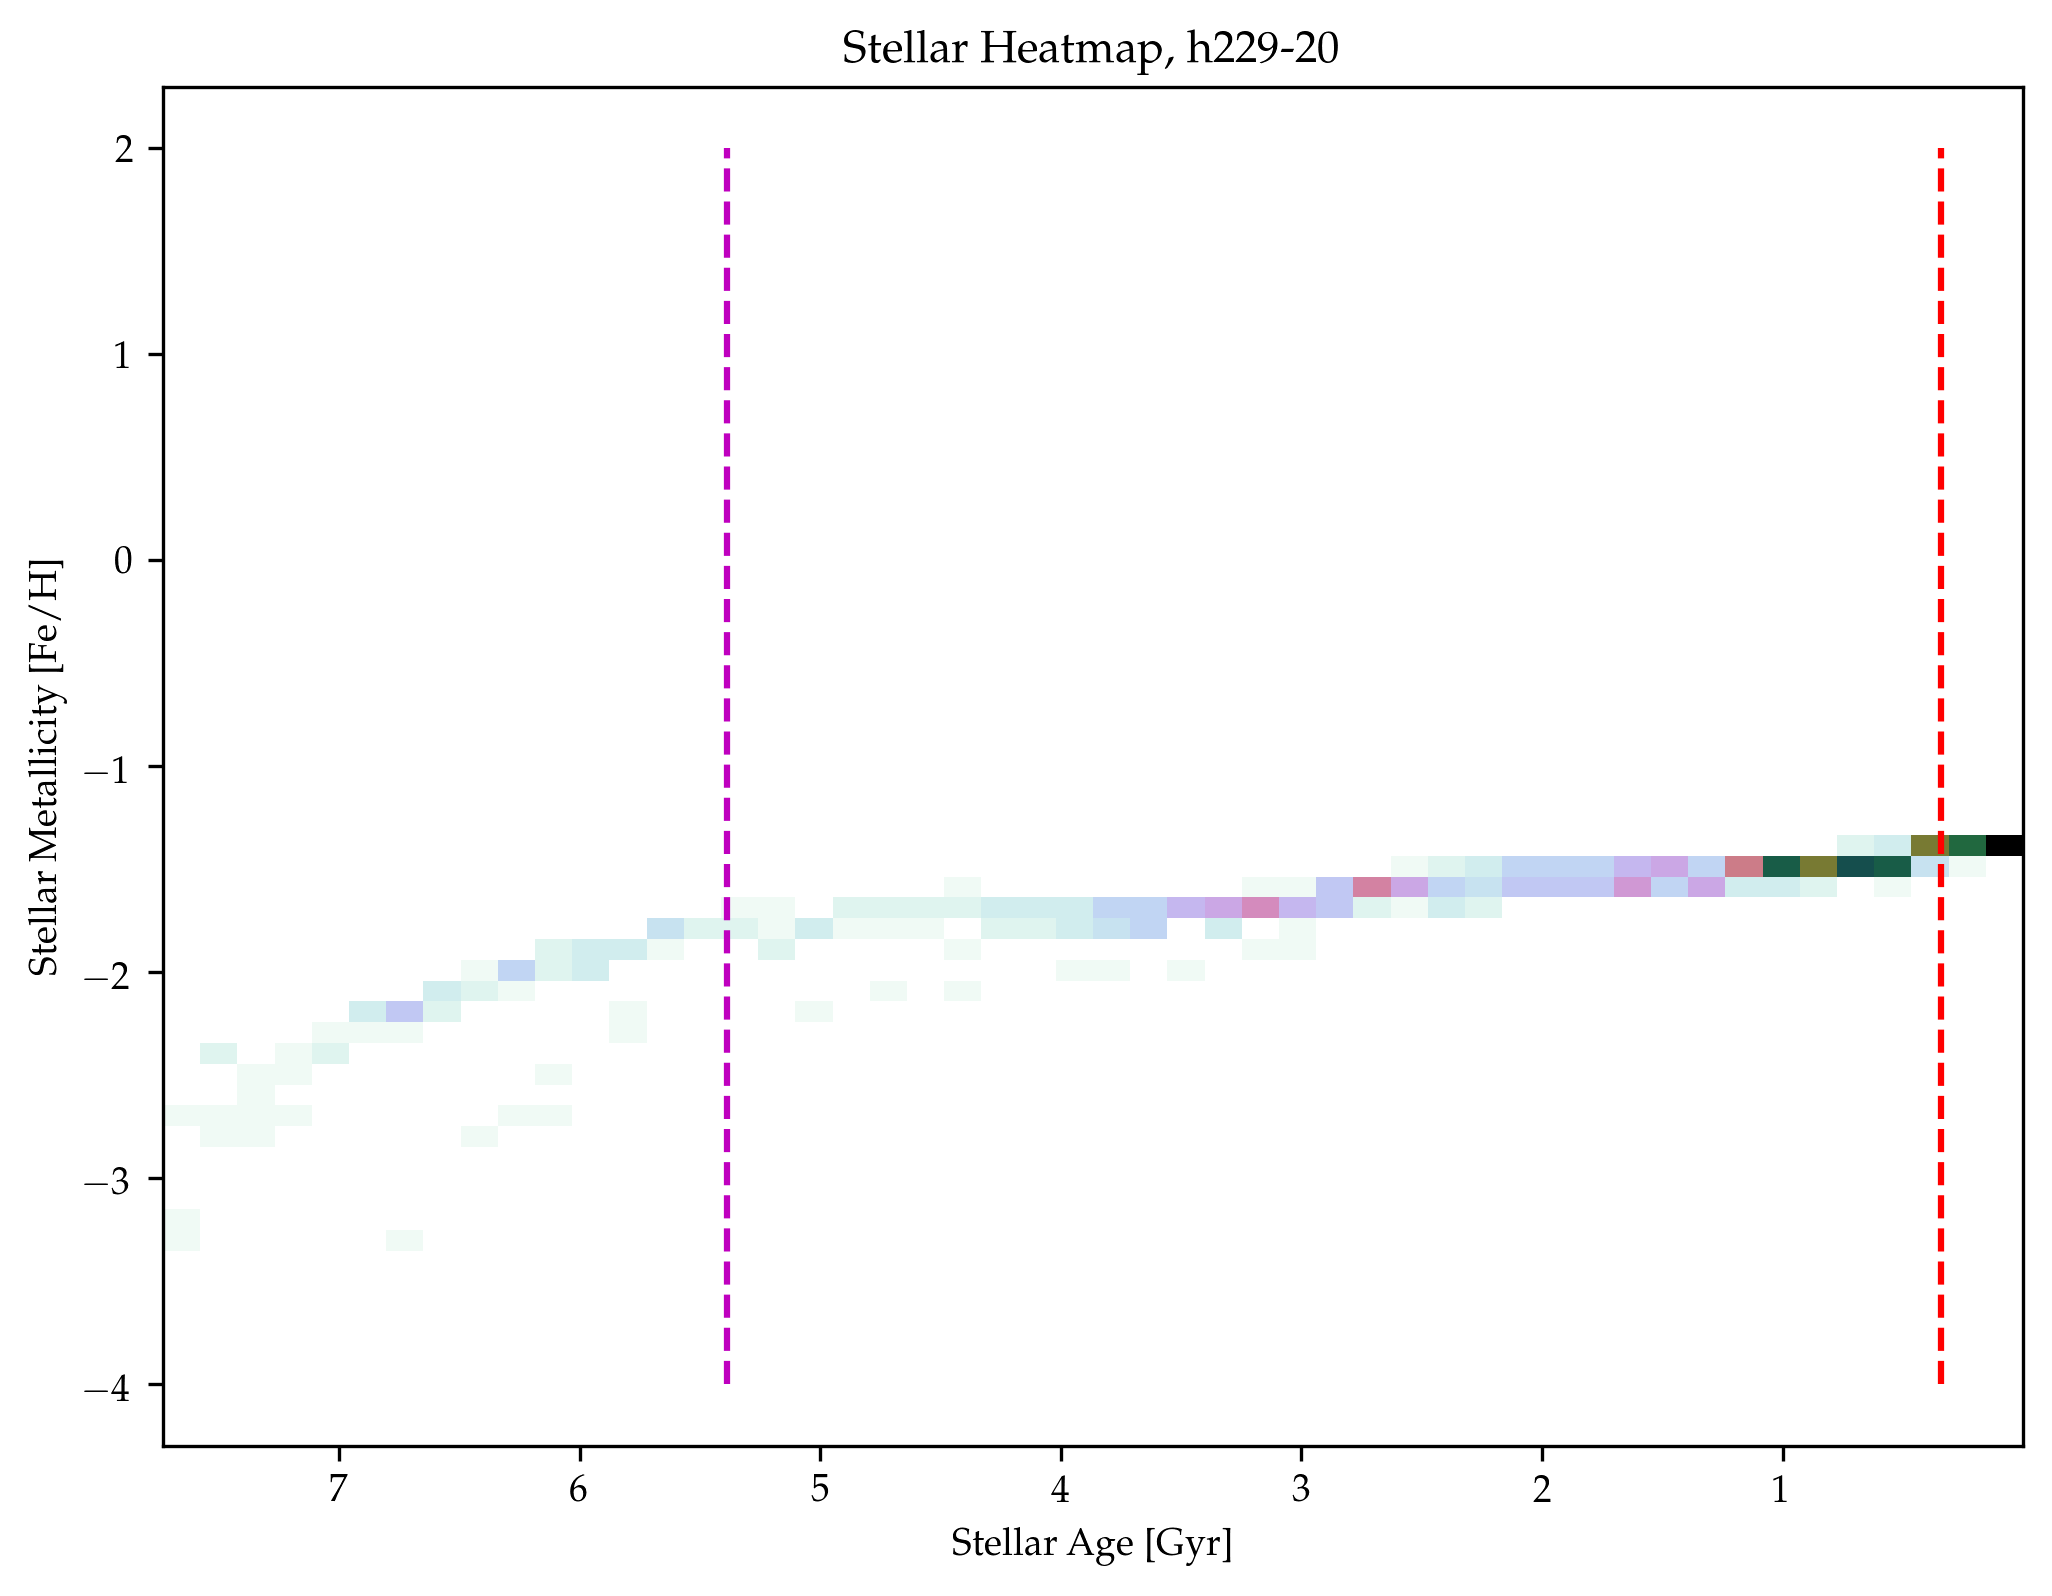

Loaded h229 halo 22


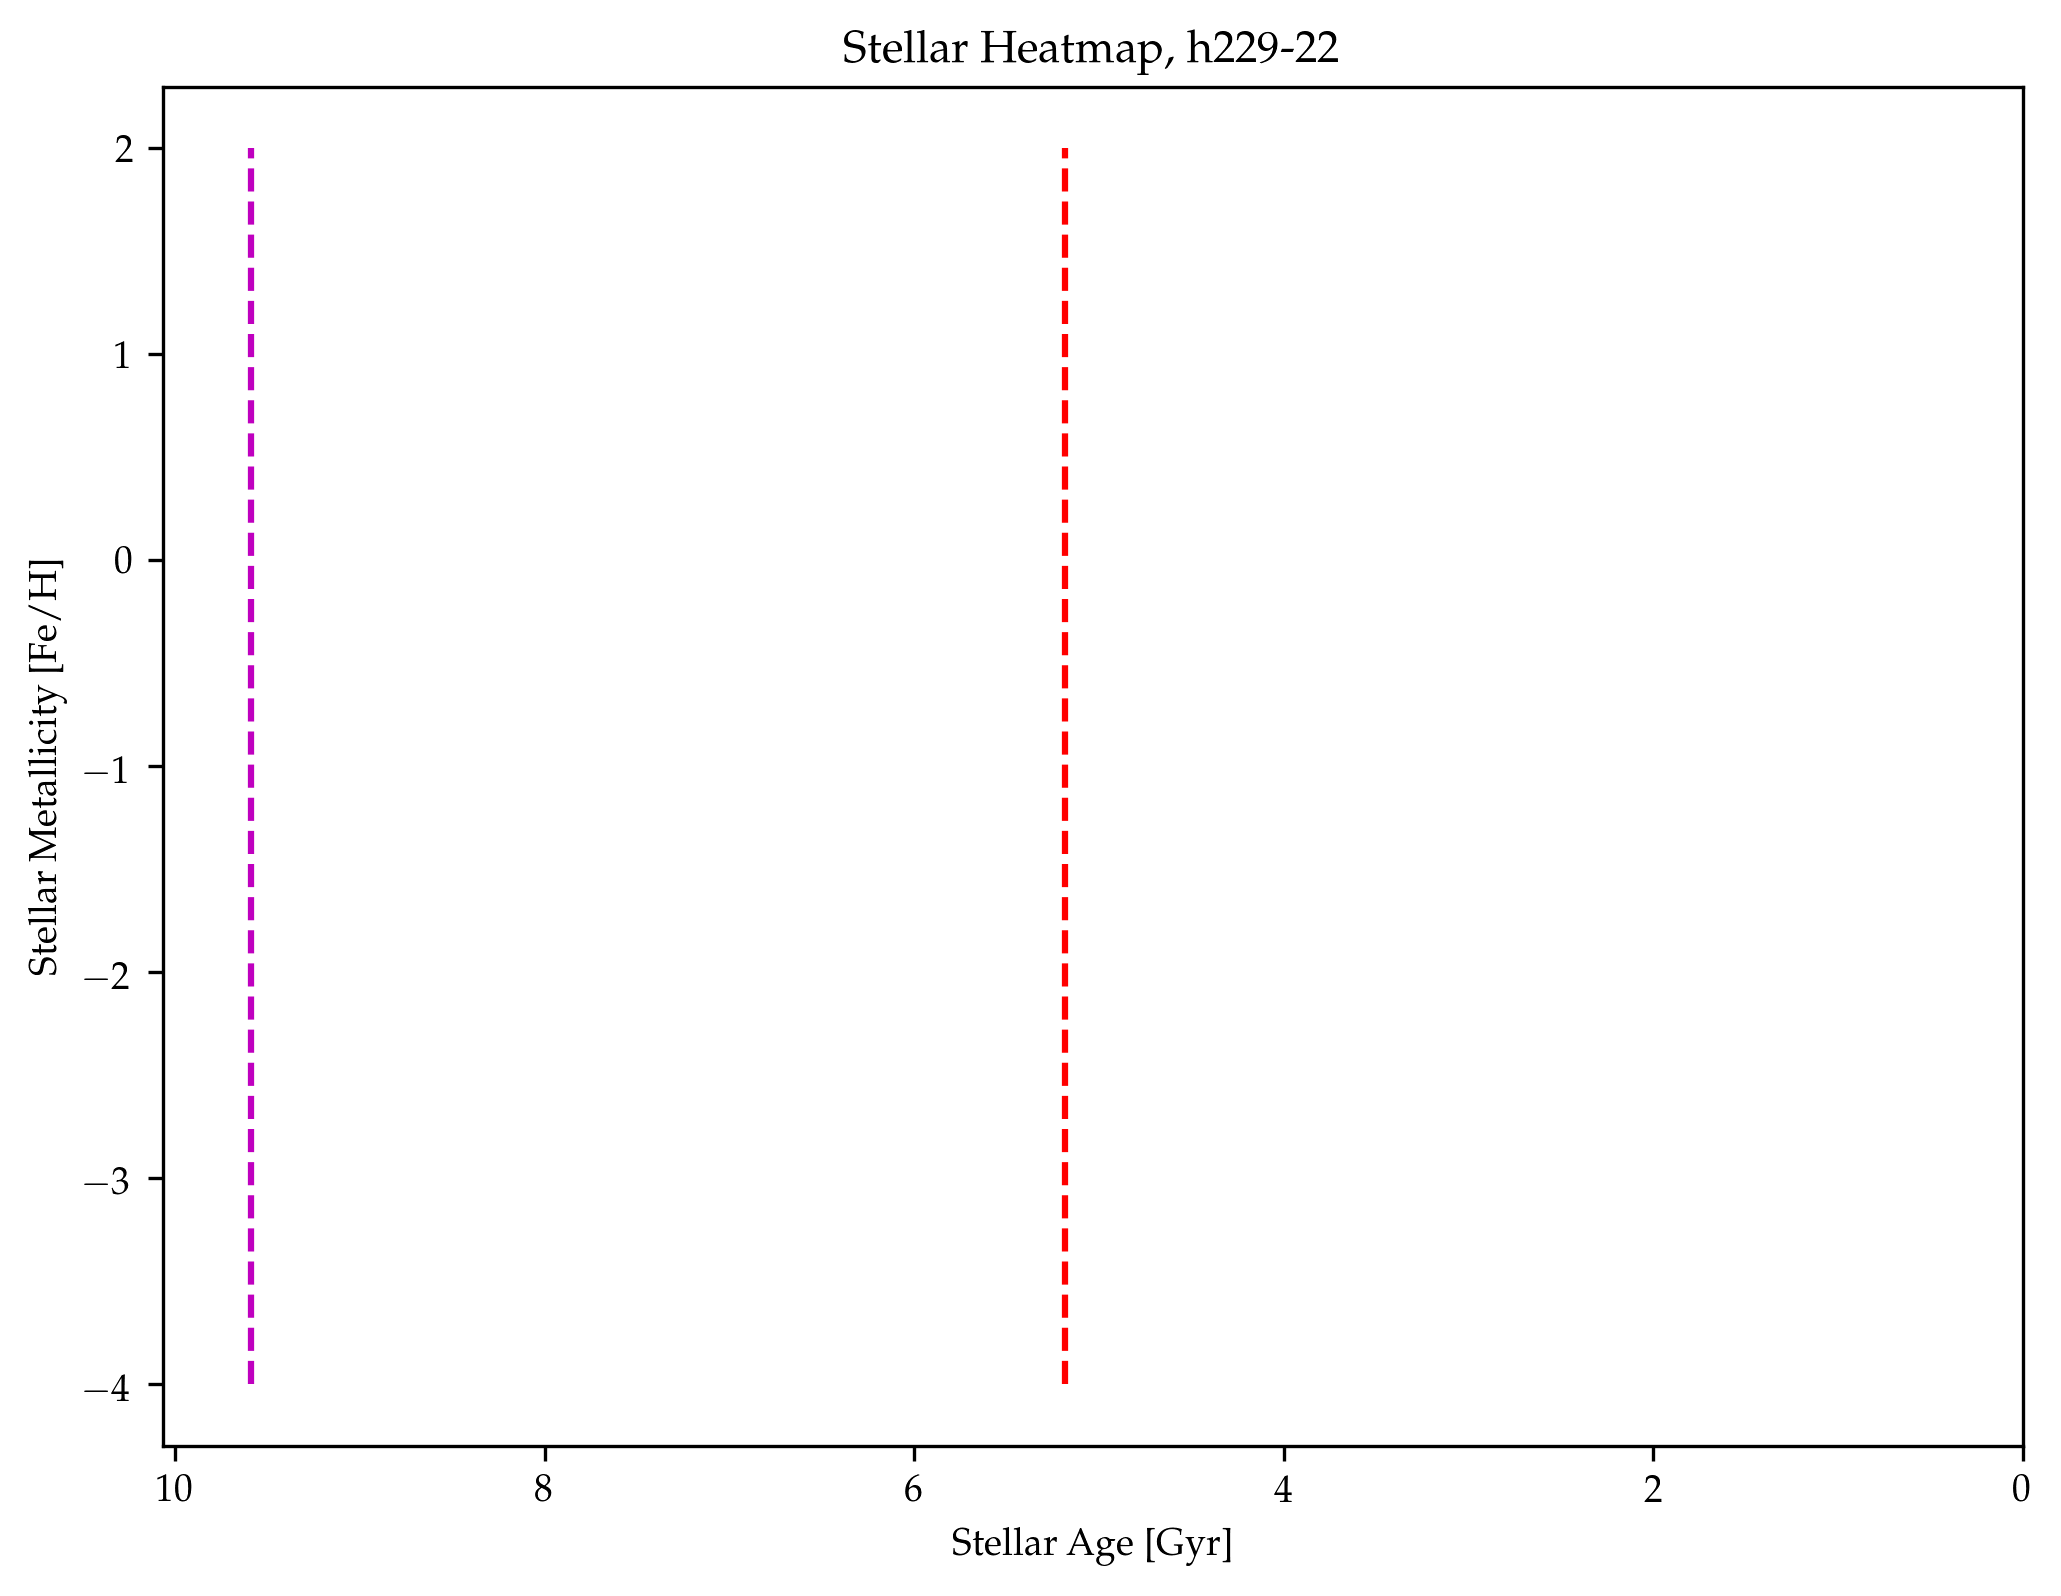

In [56]:
sims = ['h148', 'h242', 'h229']
haloids = {'h148': [28, 37, 45, 68],
           'h242': [24, 80],
           'h229': [20, 22]}

filenames = {'h148': '/home/akinshol/Data/Sims/newh148/h148.cosmo50PLK.3072g3HbwK1BH.004096',
             'h242': '/home/akinshol/Data/Sims/newh242/h242.cosmo50PLK.3072gst5HbwK1BH.004096',
             'h229': '/home/akinshol/Data/Sims/newh229/h229.cosmo50PLK.3072gst5HbwK1BH.004096'}

for sim in sims:
    s = pynbody.load(filenames[sim])
    s.physical_units()
    h = s.halos()
    
    for haloid in haloids[sim]:
        halo = h[haloid]
        print(f'Loaded {sim} halo {haloid}')
        
        age = np.array(halo.s['age'].in_units('Gyr'), dtype=float)
        feh = np.array(halo.s['feh'], dtype=float)
        mass = np.array(halo.s['mass'],dtype=float)
        
        timescales = read_timescales()
        timescales = timescales[(timescales.sim == sim) & (timescales.haloid==haloid)]
        tquench = timescales.tquench.tolist()[0]
        tinfall = timescales.tinfall.tolist()[0]
        
        n_feh = feh[feh > -4]
        n_age = age[feh > -4]

        # plt.scatter(n_age, n_feh, c='g', marker='.', s=0.1, alpha=0.1)

        heatmap, xedges, yedges = np.histogram2d(n_age, n_feh, bins=(50,20))
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        fig, ax = plt.subplots(1,1,dpi=300,figsize=(8,6))
        ax.set_title(f'Stellar Heatmap, {sim}-{haloid}')
        ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='cubehelix_r', aspect='auto')
        ax.plot([tinfall,tinfall],[-4,2],'m--')
        ax.plot([tquench,tquench],[-4,2],'r--')
        ax.set_xlabel('Stellar Age [Gyr]')
        ax.invert_xaxis()
        ax.set_ylabel('Stellar Metallicity [Fe/H]')
        plt.show()

In [ ]:
from scipy.stats import binned_statistic 

for sim in ['h148','h229','h242','h329']:
    data = read_timesteps(sim)
    z0 = read_z0(sim)
    print(f'Running for simulation {sim}')

    for haloid in haloids[sim]:
        d = data[data.z0haloid==haloid]

        # determine t_quench
        timescales = read_timescales()
        timescales = timescales[(timescales.sim == sim) & (timescales.haloid==haloid)]
        tquench_lbt = timescales.tquench.tolist()[0]
        tquench = 13.800797497330507 - tquench_lbt

        tinfall_lbt = timescales.tinfall.tolist()[0]
        tinfall = 13.800797497330507 - tinfall_lbt
        
        if np.isnan(tquench):
            continue
            
        timescale = tinfall_lbt - tquench_lbt
        print(timescale)
        
        if timescale < 0.5 or timescale > 2:
            continue
            

        z = z0[z0.haloid == haloid]
        sfh, binEdges = z.sfh.tolist()[0], z.sfhbins.tolist()[0]
        bincenters = 0.5*(binEdges[1:] + binEdges[:-1])
        
        mstar, mgas, time = np.array(d.mstar,dtype=float), np.array(d.mgas, dtype=float), np.array(d.time,dtype=float)
        mstar = mstar[np.argsort(time)]
        time = np.sort(time)
        
        s = interpolate.InterpolatedUnivariateSpline(time, mstar)
        mstar_interpolated = s(bincenters)
        
        sSFR = sfh/mstar_interpolated
        bins = np.arange(0,13.8,0.3)
        sSFR_binned = binned_statistic(bincenters, sSFR, bins=bins).statistic
        bincenters_binned = 0.5*(bins[1:] + bins[:-1])
        
            
        outflow_disk = d.outflow_23
        inflow_disk = d.inflow_23
        net = outflow_disk + inflow_disk 
        net_norm = net / mgas

        # get distributions of gas density
        times, rhos, weights, mgas_tot = np.array([]), np.array([]), np.array([]), np.array([])
        
        for mgas in d.gas_mass:
            mgas_tot = np.append(mgas_tot, np.sum(mgas))
        mgas_tot = [np.sum(mgas) for mgas in d.gas_mass]
        
        for time, rho, mgas, a in zip(d.time, d.gas_rho, d.gas_mass, d.a):
            if len(rho) != 0:
                assert len(rho)==len(mgas)
                rhos = np.append(rhos, rho*(a**3))
                weights = np.append(weights,mgas/np.sum(mgas_tot))
                times = np.append(times, [time]*len(rho))
                
        rhos = rhos / 2.453e7
        rho_mean = np.array([np.log10(np.mean(rho)/2.453e7) for rho in d.gas_rho]) # convert to amu/cc

        xbins = int((np.max(times) - np.min(times))/14 * 40)

        rhos_heatmap, xedges, yedges = np.histogram2d(times, np.log10(rhos), weights=weights,bins=(xbins,20))
        rhos_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        # get distributions of gas temperature
        times, temps, weights = np.array([]), np.array([]), np.array([])
        for time, temp, mgas in zip(d.time, d.gas_temp, d.gas_mass):
            if len(temp) != 0:
                temps = np.append(temps, temp)
                weights = np.append(weights, mgas/np.sum(mgas_tot))
                times = np.append(times, [time]*len(temp))

        temp_mean = [np.log10(np.mean(temp)) for temp in d.gas_temp]

        temps_heatmap, xedges, yedges = np.histogram2d(times, np.log10(temps), weights=weights, bins=(xbins,20))
        temps_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        fig, ax = plt.subplots(2,1,dpi=300,figsize=(10,8),sharex=True)

        ax[0].set_title(f'Gas Heatmaps, {sim}-{haloid}')

        if not np.isnan(tquench):
            ax[0].plot([tquench,tquench], [-10,10], 'r--', label='$t_{\mathrm{quench}}$')
        if not np.isnan(tinfall):
            ax[0].plot([tinfall,tinfall], [-10,10], 'm--', label='$t_{\mathrm{infall}}$')

        im = ax[0].imshow(rhos_heatmap.T, extent=rhos_extent, 
                          origin='lower', cmap='cubehelix_r', 
                          aspect='auto', vmin=0, vmax=0.02)
        ax[0].set_ylabel(r'$\log_{10}~\rho_{\mathrm{gas}}$  $[\mathrm{amu}~\mathrm{cm}^{-3}]$')
        ax[0].set_xlim(0, 14)
        ax[0].set_ylim(-7,1.2)
        ax[0].plot(d.time, rho_mean, 'b-', label='Unweighted Mean')
        #fig.colorbar(im, ax=ax[0])
        
        ax0 = ax[0].twinx()
        ax0.plot(bincenters_binned, sSFR_binned, 'k-')
        ax0.set_ylabel('sSFR [yr$^{-1}$] (binned)')
        ax0.semilogy()
        ax0.set_ylim(1e-12,2e-8)
        
        #ax[0].plot(d.time, rho_mean_unw, 'b--', linewidth=0.5, label='Unweighted Mean')
        ax[0].legend(frameon=False)

        if not np.isnan(tquench):
            ax[1].plot([tquench,tquench], [-10,5], 'r--', label='$t_{\mathrm{quench}}$')
        if not np.isnan(tinfall):
            ax[1].plot([tinfall,tinfall], [-10,5], 'm--', label='$t_{\mathrm{infall}}$')

        im = ax[1].imshow(temps_heatmap.T, extent=temps_extent, 
                          origin='lower', cmap='cubehelix_r', 
                          aspect='auto', vmin=0, vmax=0.04)
        ax[1].set_xlabel(r'Earlier $\qquad\leftarrow\qquad$ Time [Gyr] $\qquad\rightarrow\qquad$ Later')
        ax[1].set_ylabel(r'$\log_{10}~T_{\mathrm{gas}} / \mathrm{K}$')
        ax[1].set_xlim(0,14)
        ax[1].plot(d.time, temp_mean, 'b-', label='Unweighted Mean')
        #ax[1].plot(d.time, temp_mean_unw, 'b--', linewidth=0.5, label='Unweighted Mean')
        ax[1].legend(frameon=False)
        ax[1].set_ylim(3,5.5)
        #fig.colorbar(im, ax=ax[1])
        
        ax1 = ax[1].twinx()
        ax1.plot(d.time, net_norm*1e9, color='orange')
        #ax1.plot(d.time, np.abs(inflow_disk), color='orange')
        ax1.set_ylabel(r'$\dot{M}_{\mathrm{gas}} / M_{\mathrm{gas}}$ ($\times 10^{-9}$)')
        ax1.set_ylim(-1,1)
        ax1.plot([0,14], [0,0], 'k:', linewidth=1)

        plt.subplots_adjust(hspace=0.)
        plt.savefig(f'plots/GasPlots/Group2/{sim}_{haloid}.png',dpi=300)
        plt.show()